In [21]:
import pandas as pd
import random
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
random.seed(42)

## Dataset Preparation
Sampling 500 rows for graduated students and selecting the major and salary columns

In [22]:
df = pd.read_csv("../Data/students.csv")
df.head()

,stud.id,name,gender,age,height,weight,religion,nc.score,semester,major,minor,score1,score2,online.tutorial,graduated,salary
1,833917,"Gonzales, Christina",Female,19,160,64.8,Muslim,1.91,1st,Political Science,Social Sciences,NaN,NaN,0,0,NaN
2,898539,"Lozano, T'Hani",Female,19,172,73.0,Other,1.56,2nd,Social Sciences,Mathematics and Statistics,NaN,NaN,0,0,NaN
3,379678,"Williams, Hanh",Female,22,168,70.6,Protestant,1.24,3rd,Social Sciences,Mathematics and Statistics,45.0,46.0,0,0,NaN
4,807564,"Nem, Denzel",Male,19,183,79.7,Other,1.37,2nd,Environmental Sciences,Mathematics and Statistics,NaN,NaN,0,0,NaN
5,383291,"Powell, Heather",Female,21,175,71.4,Catholic,1.46,1st,Environmental Sciences,Mathematics and Statistics,NaN,NaN,0,0,NaN


In [23]:
grads = df[df['graduated'] == 1]
grads.shape

(1753, 16)

In [24]:
len(grads['stud.id'].unique())

1753

In [25]:
num_samples = 500

ids = grads['stud.id'].to_list()
sample = random.sample(ids, num_samples)

sample_df = grads[grads['stud.id'].isin(sample)].reset_index(drop = True)
sample_df.head()

,stud.id,name,gender,age,height,weight,religion,nc.score,semester,major,minor,score1,score2,online.tutorial,graduated,salary
0,354271,"Covar Orendain, Christopher",Male,23,185,84.6,Orthodox,1.00,4th,Environmental Sciences,Mathematics and Statistics,71.0,76.0,1,1,40552.790243
1,763393,"Woolsey, Bronson",Male,24,182,80.1,Protestant,1.09,5th,Economics and Finance,Social Sciences,61.0,73.0,1,1,50617.641870
2,835757,"Lujan, Malia",Female,22,172,68.3,Protestant,2.12,4th,Mathematics and Statistics,Environmental Sciences,86.0,92.0,1,1,35598.881686
3,902697,"Phan, Edeer",Male,19,160,62.2,Catholic,2.92,5th,Environmental Sciences,Economics and Finance,78.0,75.0,1,1,39703.744885
4,841076,"Pacheco, Cydney",Female,19,167,72.8,Other,2.73,>6th,Biology,Political Science,74.0,81.0,0,1,49111.427488


In [26]:
sample_df.shape

(500, 16)

In [27]:
sample_df = sample_df[['major', 'salary']]
groups = sample_df.groupby("major").count().reset_index()
groups.head()

,major,salary
0,Biology,104
1,Economics and Finance,84
2,Environmental Sciences,99
3,Mathematics and Statistics,80
4,Political Science,72


## Normality Assumption Check
In order to do this we will plot Q-Q Plots for each grouped variable

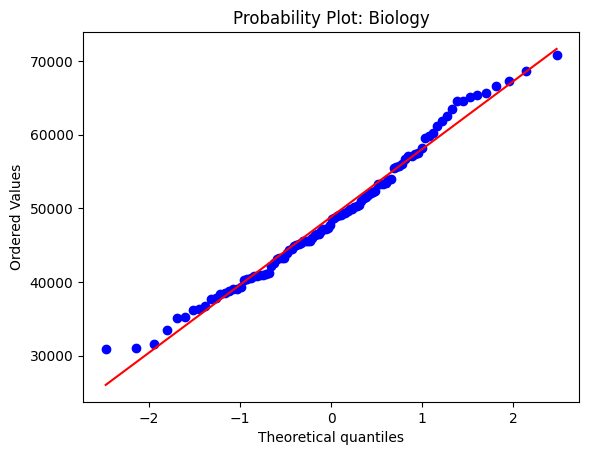

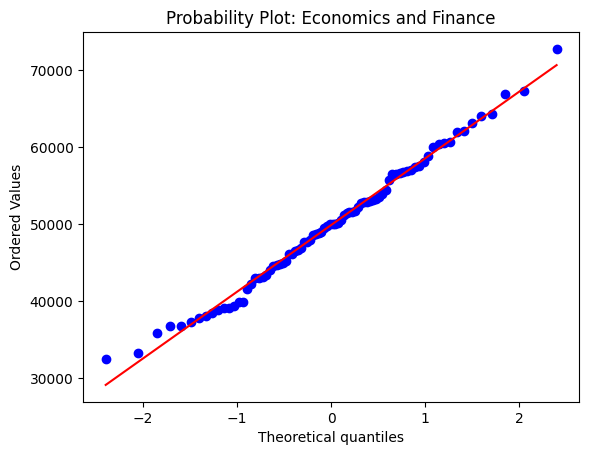

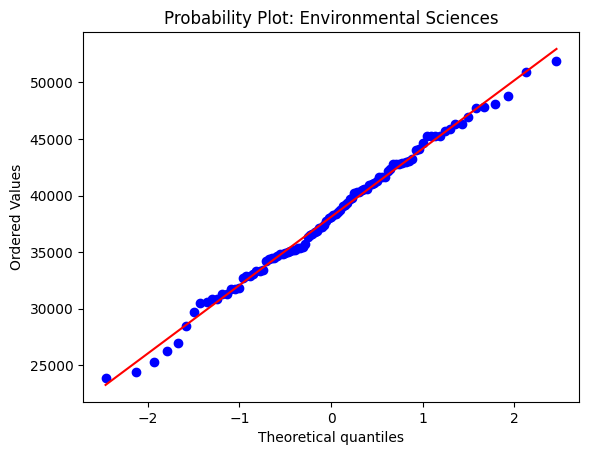

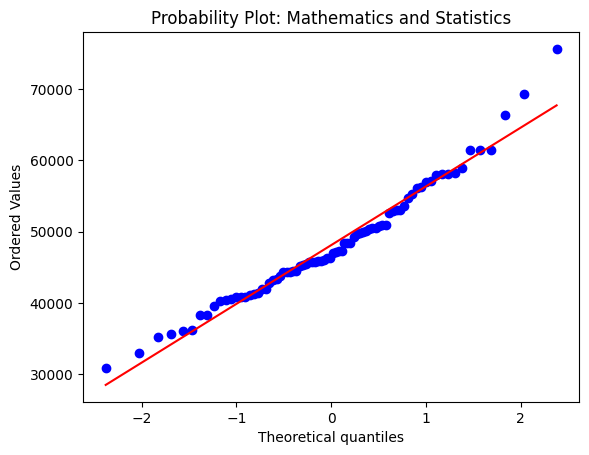

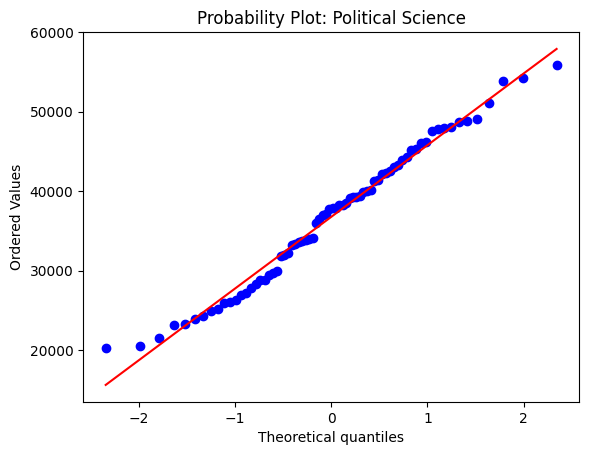

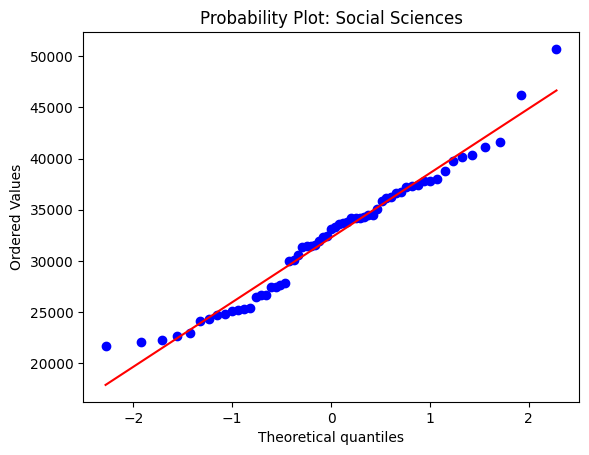

In [28]:
unique_majors = groups['major']

for major in unique_majors:
    stats.probplot(sample_df[sample_df['major'] == major]['salary'], dist="norm", plot=plt)
    plt.title("Probability Plot: {}".format(major))
    plt.show()

#### The values shown here are largely linear which means that our sampled distribution is pretty close to that of a normal disttribution.

## Homogeneity of Variance Check
Calculating the ratio of the largest to the smallest sample standard deviation

In [29]:
ratio = sample_df.groupby("major").std().max()/sample_df.groupby("major").std().min()
ratio

salary    1.53265
dtype: float64

The ratio is 1.7, which is lesser than our threshold of 2 from the rule of thumb.

#### Therefore we conclude that the assumptions are fulfilled

## ANOVA Test

In [30]:
## Creating our Base ANOVA table
data = [["Between Groups", "", "", "", "", "", ""],
        ["Within Groups", "", "", "", "", "", ""],
        ["Total", "", "", "", "", "", ""]]

anova_columns = ["Source of Variation", "SS", "df", "Mean Squares", "F", "P-Value", "F Crit"]

anova_table = pd.DataFrame(data, columns = anova_columns)
anova_table.set_index("Source of Variation", inplace = True)

anova_table.head()

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,,,,,,
Within Groups,,,,,,
Total,,,,,,


In [31]:
## Calculating SSTR and updating ANOVA Table

x_bar = sample_df["salary"].mean()

SSTR = sample_df.groupby("major").count() * (sample_df.groupby("major").mean() - x_bar)**2
anova_table["SS"]["Between Groups"] = SSTR["salary"].sum()

In [32]:
anova_table.head()

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,,,,,
Within Groups,,,,,,
Total,,,,,,


In [33]:
## Calculating SSE and updating ANOVA Table
SSE = (sample_df.groupby("major").count() - 1) * sample_df.groupby("major").std()**2
anova_table["SS"]["Within Groups"] = SSE["salary"].sum()

In [34]:
anova_table.head()

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,,,,,
Within Groups,31460679390.040977,,,,,
Total,,,,,,


In [35]:
## Calculating SSTO
SSTO = SSTR["salary"].sum() + SSE["salary"].sum()
anova_table["SS"]["Total"] = SSTO

In [36]:
anova_table.head()

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,,,,,
Within Groups,31460679390.040977,,,,,
Total,53260053328.421127,,,,,


In [37]:
## Updating Degrees of Freedom
anova_table["df"]["Between Groups"] = sample_df["major"].nunique() - 1
anova_table["df"]["Within Groups"] = sample_df.shape[0] - sample_df["major"].nunique()
anova_table["df"]["Total"] = sample_df.shape[0] - 1

In [38]:
anova_table.head()

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,5,,,,
Within Groups,31460679390.040977,494,,,,
Total,53260053328.421127,499,,,,


In [39]:
## Calculating the Mean of Sum of Squares
anova_table["Mean Squares"] = anova_table["SS"]/anova_table["df"]
anova_table.head()

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,5,4359874787.676029,,,
Within Groups,31460679390.040977,494,63685585.8098,,,
Total,53260053328.421127,499,106733573.804451,,,


In [44]:
## Calculating the F-Statistic for the ANOVA Test
F = anova_table["Mean Squares"]["Between Groups"]/anova_table["Mean Squares"]["Within Groups"]
anova_table["F"]["Between Groups"] = F
anova_table

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,5,4359874787.676029,68.459365,,
Within Groups,31460679390.040977,494,63685585.8098,,,2.592178
Total,53260053328.421127,499,106733573.804451,,,


In [45]:
## Getting the P Value for this F Value
anova_table["P-Value"]["Between Groups"] = 1 - stats.f.cdf(F, anova_table["df"]["Between Groups"], anova_table["df"]["Within Groups"])
anova_table

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,5,4359874787.676029,68.459365,0.0,
Within Groups,31460679390.040977,494,63685585.8098,,,2.592178
Total,53260053328.421127,499,106733573.804451,,,


In [46]:
## Comparing with F-Critical
alpha = 0.05/2
anova_table["F Crit"]["Between Groups"] = stats.f.ppf(1-alpha, anova_table["df"]["Between Groups"], anova_table["df"]["Within Groups"])

anova_table

,SS,df,Mean Squares,F,P-Value,F Crit
Source of Variation,,,,,,
Between Groups,21799373938.380146,5,4359874787.676029,68.459365,0.0,2.592178
Within Groups,31460679390.040977,494,63685585.8098,,,2.592178
Total,53260053328.421127,499,106733573.804451,,,


The P Value for this is less than the significant threshold. Alternatively, the F Value is greater than the F-Critical Value. Therefore we reject the Null Hypothesis and say that the means of the true distributions of the Salaries for different fields of study being the same is n